#Emittance Checks on the matched bunch for different lattices

For matching to the nonlinear lattice, I included a quick script to calculate the statistical emittance. I want to check this against other bunch methods and also verify that the results make sense for the matched IOTA bunch.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 10/09/2015 

CPython 2.7.10
IPython 3.1.0


In [21]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow
import scipy

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import elliptic_sp
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch

In [4]:
#dictionary of lattices
lattices = {}
lattices['t2_1pair_min'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_1s_approx.madx'
lattices['t3_1pair_min_NLL'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_1s_approx_NLL.madx'
lattices['t2_2pair_min'] = '/Users/ncook/Synergia_Tests/IOTA6-6_Chromaticity_Tests/2I_equal_chrome_mink2/lattice_2IO_2s_min.madx'
lattices['t1_2IO'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_center.madx'
lattices['t3_2IO_NLL'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_nll_center.madx'
lattices['t2_2IO_chrome'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_chrome_center.madx'
lattices['t3_2IO_chrome_NLL'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_chrome_center_NLL.madx'
lattices['t3_2IO_synchrome_NLL'] = '/Users/ncook/Synergia_Tests/lattices/6-6_chromaticity/lattice_2IO_nll_fullcorrection_center.madx'

###First look at a standard Gaussian bunch to check agreement

In [36]:
#static simulation quantities
turns = 1000
order = 1
nsteps_per_element = 4
n_macro = 1000
#dpop = 0.001
dpop = 0.01 #one percent!

tval = 0.4
cval = 0.01

emittances = [1.0e-6]

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t1_2IO'])
#lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['2IO_NLL'])

name = 't1_2IO'
outputdir = "{}_turns_order_{}_{}".format(turns,order,name)

for elem in lattice.get_elements():
    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'nllens':
#    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'sextupole':
#    elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps = len(lattice.get_elements())*nsteps_per_element
opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
#opts.emitx = 1.0e-5
#workflow.make_path(outputdir)

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
#vals = get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
#opts.betae = vals[3]
#opts.alphae = 0 #fixed 0 alpha for center
#opts.beta0 = vals[3]

opts.emits = emittances
opts.lattice = lattice
#opts.dpop = 0.4/100 #0.4% dpop
opts.dpop = dpop #0.1% dpop

opts.emitx = opts.emits[0]
opts.emity = opts.emits[0]

#Construct a Gaussian matched bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 


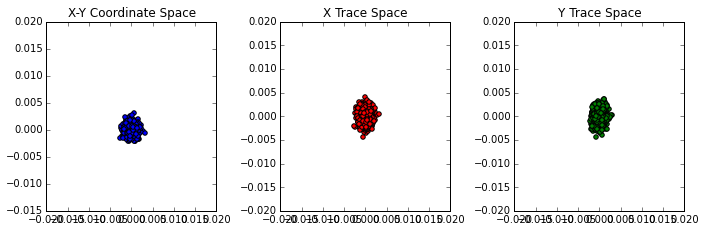

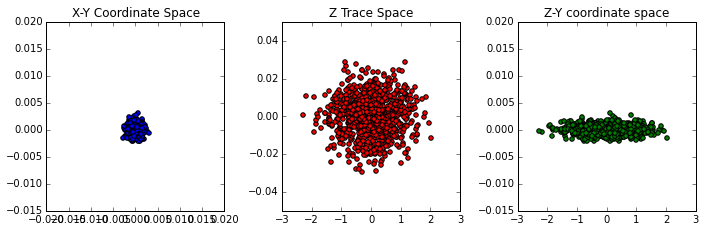

In [37]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [39]:
emit_x = basic_calcs.get_emittance('x',myBunch)
emit_y = basic_calcs.get_emittance('y',myBunch)

print 'Emittance in x is: {}'.format(emit_x)
print 'Emittance in y is: {}'.format(emit_y)

Emittance in x is: 1.00000000006e-06
Emittance in y is: 1.00000000169e-06


We have agreement. I should note that we are generating bunches with geometric emittance 1 mm-mrad, so I still need to account for normalization.

###Now check nonlinear bunch!

In [32]:
#static simulation quantities
turns = 1000
order = 1
nsteps_per_element = 4
n_macro = 1000
#dpop = 0.001
dpop = 0.01 #one percent!

tval = 0.4
cval = 0.01

emittances = [1.0e-6]

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t3_2IO_NLL'])
#lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['2IO_NLL'])

name = 't3_2IO_NLL'
outputdir = "{}_turns_order_{}_{}".format(turns,order,name)

for elem in lattice.get_elements():
    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'nllens':
#    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'sextupole':
#    elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps = len(lattice.get_elements())*nsteps_per_element
opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
#opts.emitx = 1.0e-5
#workflow.make_path(outputdir)

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
opts.betae = vals[3]
opts.alphae = 0 #fixed 0 alpha for center
opts.beta0 = vals[3]

opts.emits = emittances
opts.lattice = lattice
#opts.dpop = 0.4/100 #0.4% dpop
opts.dpop = dpop #0.1% dpop

opts.emitx = opts.emits[0]
opts.emity = opts.emits[0]


#construct a bunch and make sure to add longitudinal momentum variation
particles = EllipticBeam6D.toyEllipticalBeam6D(opts)

for index in range(len(opts.emits)):
    bunch = particles[index]
    initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
    bunch_mean = np.mean(initialH)
    bunch_std = np.std(initialH)
    bunch_var = (bunch_std/bunch_mean)*100
    print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
    #now add longitudinal momentum variation
    #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
    bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))

print
opts.num_total_particles = opts.macro_particles*len(opts.emits)
opts.tracked_particles = opts.num_total_particles

particles_file = 'myBunch' + str(name) + '.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #potential workaround
ref = lattice.get_reference_particle()
myEllipticBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm, bucket_length)
local_particles = myEllipticBunch.get_local_particles()
local_particles[:,:] = particles.reshape((opts.num_total_particles,7))[::]

Constructed bunch with 1000 macroparticles, having mean H: 9.94538040931e-07 and std: 1.0852191697%



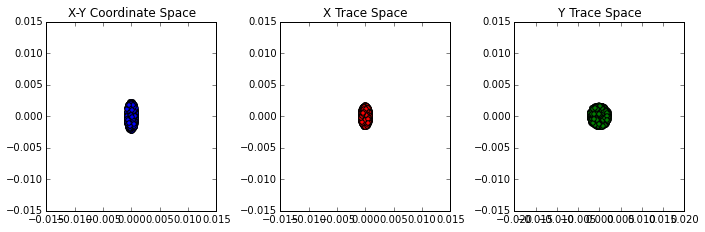

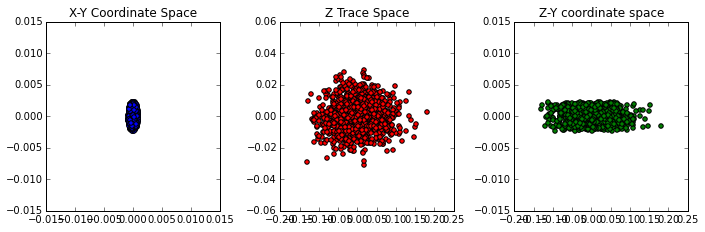

In [33]:
pltbunch.plot_bunch(myEllipticBunch)
pltbunch.plot_long(myEllipticBunch)

In [35]:
emit_x_e = basic_calcs.get_emittance('x',myEllipticBunch)
emit_y_e = basic_calcs.get_emittance('y',myEllipticBunch)

print 'Emittance in x is: {}'.format(emit_x_e)
print 'Emittance in y is: {}'.format(emit_y_e)

Emittance in x is: 3.83946168679e-07
Emittance in y is: 1.0418715155e-06


In [51]:
ref = lattice.get_reference_particle()
opts.betaz = ref.get_beta()
opts.gammaz = ref.get_gamma()

nemit_x_e = basic_calcs.get_normalized_emittance('x',myEllipticBunch, opts.betaz, opts.gammaz)
nemit_y_e = basic_calcs.get_normalized_emittance('y',myEllipticBunch, opts.betaz, opts.gammaz)

print 'Normalized emittance in x is: {}'.format(nemit_x_e)
print 'Normalized emittance in y is: {}'.format(nemit_y_e)

Normalized emittance in x is: 2.8046576196e-08
Normalized emittance in y is: 7.61068379627e-08


####Now adjust script to construct a beam with single particle Hamiltonian corresponding to the proper normalized emittance of the beam...

I suppose the best way to consider this is to increase the SPH value of the bunch until the RMS normalized emittance = 0.3 mm-mrad?

In [52]:
#static simulation quantities
turns = 1000
order = 1
nsteps_per_element = 4
n_macro = 1000
#dpop = 0.001
dpop = 0.01 #one percent!

tval = 0.4
cval = 0.01

emittances = [1.0e-6]

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t3_2IO_NLL'])
#lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['2IO_NLL'])

name = 't3_2IO_NLL'
outputdir = "{}_turns_order_{}_{}".format(turns,order,name)

for elem in lattice.get_elements():
    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'nllens':
#    elem.set_string_attribute("extractor_type", "chef_propagate")
#if elem.get_type() == 'sextupole':
#    elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps = len(lattice.get_elements())*nsteps_per_element
opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
#opts.emitx = 1.0e-5
#workflow.make_path(outputdir)

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
opts.betae = vals[3]
opts.alphae = 0 #fixed 0 alpha for center
opts.beta0 = vals[3]

opts.emits = emittances
opts.lattice = lattice
#opts.dpop = 0.4/100 #0.4% dpop
opts.dpop = dpop #0.1% dpop

opts.emitx = opts.emits[0]
opts.emity = opts.emits[0]

ref = lattice.get_reference_particle()
opts.betaz = ref.get_beta()
opts.gammaz = ref.get_gamma()

In [62]:
#do a simple search
goal = 0.3e-6
tol = 0.1e-8
cost = 1 #placeholder

while cost > tol:
    #construct a bunch and make sure to add longitudinal momentum variation
    particles = EllipticBeam6D.toyEllipticalBeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        bunch_mean = np.mean(initialH)
        bunch_std = np.std(initialH)
        bunch_var = (bunch_std/bunch_mean)*100
        print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))

    print
    opts.num_total_particles = opts.macro_particles*len(opts.emits)
    opts.tracked_particles = opts.num_total_particles

    particles_file = 'myBunch' + str(name) + '.txt'
    comm = synergia.utils.Commxx(True)
    bucket_length = 0.05 #potential workaround
    ref = lattice.get_reference_particle()
    myEllipticBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm, bucket_length)
    local_particles = myEllipticBunch.get_local_particles()
    local_particles[:,:] = particles.reshape((opts.num_total_particles,7))[::]
    
    #Now check emittance and calculate cost

    nemit_x_e = basic_calcs.get_normalized_emittance('x',myEllipticBunch, opts.betaz, opts.gammaz)
    nemit_y_e = basic_calcs.get_normalized_emittance('y',myEllipticBunch, opts.betaz, opts.gammaz)

    print 'Normalized emittance in x is: {}'.format(nemit_x_e)
    print 'Normalized emittance in y is: {}'.format(nemit_y_e)
    print ''
    
    #cost will be driven by the smaller of the two dimensions (e.g. horizontal) since this would seem to be the limiting factor
    cost = np.abs(nemit_x_e - goal)
    
    #if the normalized emittance is still smaller than the goal, then increase opts.emits[0]
    if nemit_x_e < goal:
        current = opts.emits[0]
        opts.emits[0] = current*1.02 #increase by a factor 1.1
    else:
        cost = 0 #we've gone over our goal and will simply stop

Constructed bunch with 1000 macroparticles, having mean H: 6.82645792072e-06 and std: 2.84686118044%

Normalized emittance in x is: 2.06617835787e-07
Normalized emittance in y is: 4.51527608707e-07

Constructed bunch with 1000 macroparticles, having mean H: 6.96307408104e-06 and std: 2.86410452811%

Normalized emittance in x is: 2.10973678166e-07
Normalized emittance in y is: 4.59613540782e-07

Constructed bunch with 1000 macroparticles, having mean H: 7.10172397479e-06 and std: 2.87256208674%

Normalized emittance in x is: 2.15764185731e-07
Normalized emittance in y is: 4.67233504019e-07

Constructed bunch with 1000 macroparticles, having mean H: 7.24179193892e-06 and std: 2.91718425204%

Normalized emittance in x is: 2.19945190276e-07
Normalized emittance in y is: 4.7577808376e-07

Constructed bunch with 1000 macroparticles, having mean H: 7.38640053974e-06 and std: 2.94672482918%

Normalized emittance in x is: 2.24884126834e-07
Normalized emittance in y is: 4.83550302286e-07

Constr

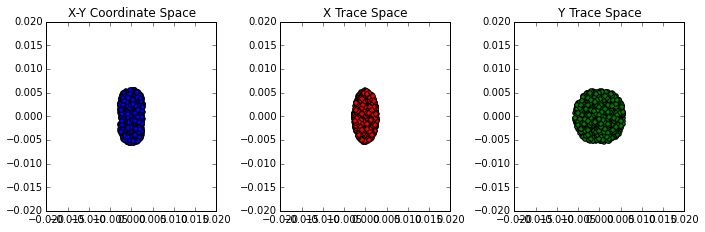

In [63]:
pltbunch.plot_bunch(myEllipticBunch)

It looks like in order to hit the normalized emittance properly, we need a bunch with $H_0 = 9.74 \times 10^{-6}$ 

##Perform a run with such a bunch and 0.1% energy spread in the uncorrected lattice

We will hardcode the output directory here.

In [70]:
outputdir = 'LargeBunch_1000turns_t3_2IO_NLL'
opts.output_dir = outputdir
workflow.make_path(opts.output_dir)

Construct bunch with smaller (0.1%) energy spread

In [75]:
opts.dpop = 0.001
particles = EllipticBeam6D.toyEllipticalBeam6D(opts)

for index in range(len(opts.emits)):
    bunch = particles[index]
    initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
    bunch_mean = np.mean(initialH)
    bunch_std = np.std(initialH)
    bunch_var = (bunch_std/bunch_mean)*100
    print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
    #now add longitudinal momentum variation
    #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
    bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))

print
opts.num_total_particles = opts.macro_particles*len(opts.emits)
opts.tracked_particles = opts.num_total_particles

particles_file = 'myBunch' + str(name) + '.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #potential workaround
ref = lattice.get_reference_particle()
myBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm, bucket_length)
local_particles = myBunch.get_local_particles()
local_particles[:,:] = particles.reshape((opts.num_total_particles,7))[::]

Constructed bunch with 1000 macroparticles, having mean H: 9.6153072273e-06 and std: 3.26846801103%



In [79]:
#Attempt to run this bunch through the lattice with NLL elements
#construct a bunch simulator and add diagnostics
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

#populate the dictionary storing relevant simulation parameters, objects, and pointers to data
simulations = {}
simulations[name] = {}

current = simulations[name]
current['lattice'] = lattice
current['tune'] = opts.new_tune
current['outputdir'] = outputdir
current['lattice_simulator'] = lattice_simulator
current['stepper'] = stepper
current['opts'] = opts
#current['R_matrix'] = toy_R
current['vals'] = vals
#current['turn_action'] = turn_action
current['bunch'] = myBunch
current['bunch_simulator'] = bunch_simulator
current['turns'] = turns


print "Performing simulation for lattice " + str(name) + "."

#now perform the simulation - 0.4s per turn for 4 steps per element and full chef
opts.turns = turns

#ignore checkpointing for now
opts.checkpointperiod = turns+1
opts.maxturns = turns+1

propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

Performing simulation for lattice t3_2IO_NLL.


/Users/ncook/.virtualenvs/synergiaenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


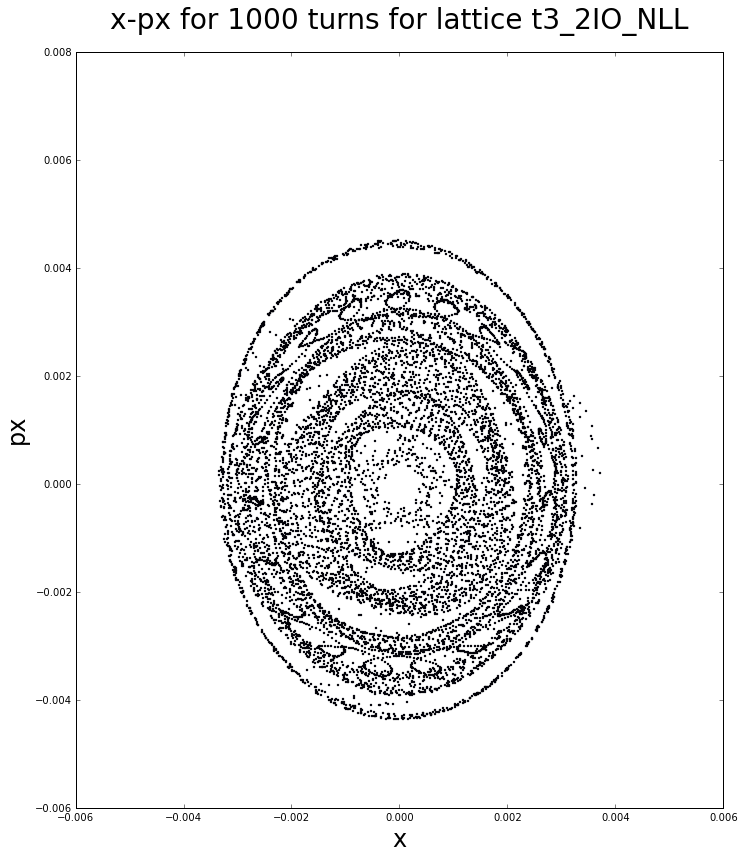

In [80]:
opts.plots = ['x','px']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.save = True
opts.num = 10
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

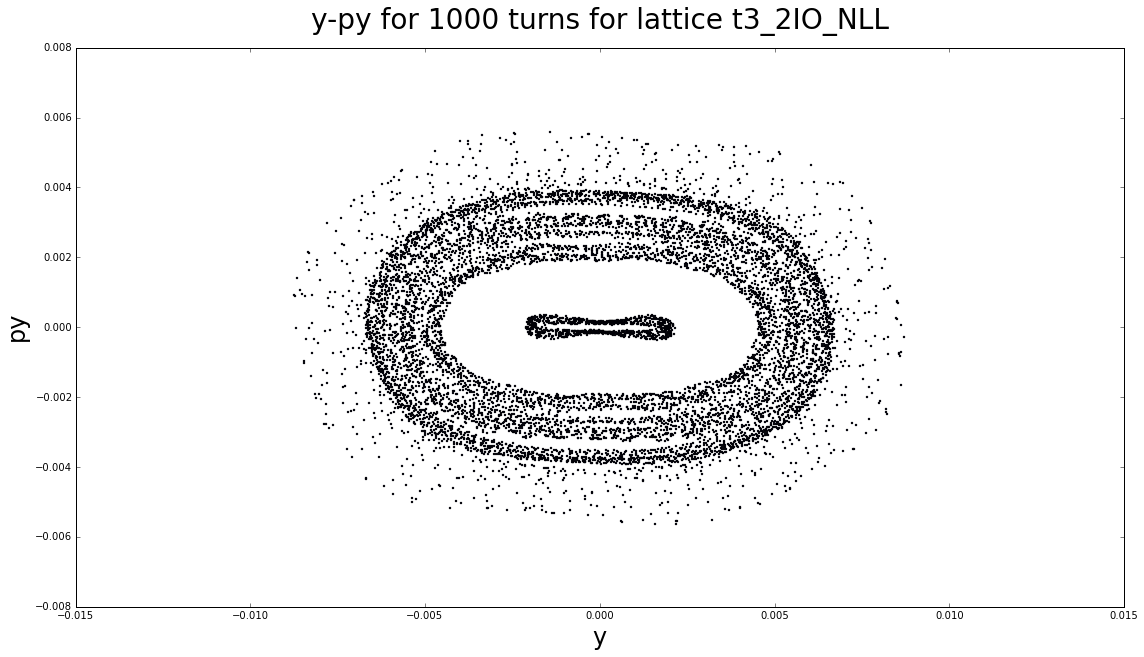

In [81]:
opts.plots = ['y','py']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.save = True
opts.num = 10
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

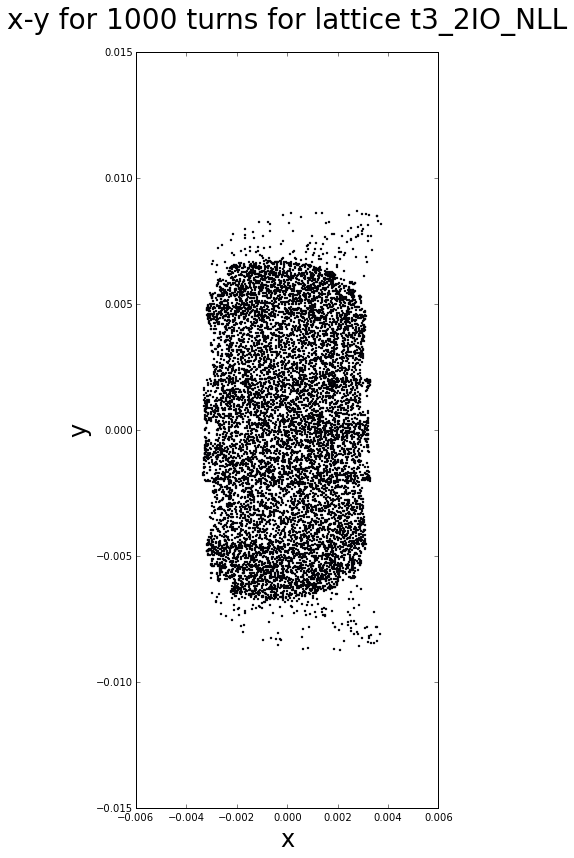

In [82]:
opts.plots = ['x','y']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.save = True
opts.num = 10
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

In [83]:
HS, IS = elliptic_sp.toy_analyze_invariant(opts)
h0_v = np.mean(HS[:,3]) #this gets us our mean std for single particle variations in H0
print "{}% variation in H0 for run {}".format(h0_v,opts.name)

Adjusting analysis to account for lost particles
12.4576359782% variation in H0 for run t3_2IO_NLL
